# Book-Crossing: Analyzing & Cleaning the dataset
## About the data

This dataset contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

> ### Dataset description:

> **BX-Books.csv** has 8 columns which include information about books.
We can uniquely identify each book with the help of ISBN(International Standard Book Number).
The title, author,publisher and year of publication of each book have been listed.
The last three columns include the URLs for different sizes of images.

> **BX-Users.csv** lists the age and location of a user along with their User-ID.

> **BX-Book-Ratings.csv** contains book ratings given by users. The User-ID and ISBN have also been provided.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from PIL import Image as im
from IPython.core.display import Image


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/bookcrossing-dataset/Books Data with Category Language and Summary/Preprocessed_data.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv
/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv


## Reading the data

In [2]:
#Users
u_cols = ['user_id', 'location', 'age'] #cria novos nomes pra colunas
users = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)

#Books #cria novos nomes pra colunas
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings #cria novos nomes pra colunas
r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/kaggle/input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

In [3]:
users.head()

,user_id,location,age
0,User-ID,Location,Age
1,1,"nyc, new york, usa",NaN
2,2,"stockton, california, usa",18
3,3,"moscow, yukon territory, russia",NaN
4,4,"porto, v.n.gaia, portugal",17


In [4]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...


In [5]:
ratings.head()

,user_id,isbn,rating
0,User-ID,ISBN,Book-Rating
1,276725,034545104X,0
2,276726,0155061224,5
3,276727,0446520802,0
4,276729,052165615X,3


In [6]:
#elimina a linha 0 de todos os datasets (que sao os antigos nomes das colunas do dataset)
users = users.drop(users.index[0])
books = books.drop(books.index[0])
ratings = ratings.drop(ratings.index[0])

## Changing variable types

In [7]:
ratings.dtypes

user_id    object
isbn       object
rating     object
dtype: object

In [8]:
users.dtypes

user_id     object
location    object
age         object
dtype: object

In [9]:
books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
img_s                  object
img_m                  object
img_l                  object
dtype: object

In [10]:
#mudando os dtypes das variáveis de object para float e int
users['age'] = users['age'].astype(float)
users['user_id'] = users['user_id'].astype(int)
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)
books['year_of_publication'] = books['year_of_publication'].astype(int)

## Dealing with missing data

### User dataset

In [11]:
#quantos valores nulos tem no dataset
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [12]:
#descreve os valores estatitisticos para a variavel da idade
users.age.describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: age, dtype: float64

De acordo com a função Describe(), a idade máxima no dataset é 244, e a mínima é 0. O que indica a presença de Outliers.

In [13]:
#se idade > 99 e <5, transformar em valor nulo
users.loc[(users.age>99) | (users.age<5),'age'] = np.nan
#substituir todas as idades nulas pela média de idades no dataset
users.age = users.age.fillna(users.age.mean())

### Ratings dataset

In [14]:
#quantos valores nulos tem no dataset
ratings.isnull().sum()

user_id    0
isbn       0
rating     0
dtype: int64

### Book dataset

In [15]:
#quantos valores nulos tem no dataset
books.isnull().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
img_s                  0
img_m                  0
img_l                  0
dtype: int64

In [16]:
#mostrar quais livros tem o publisher faltando
books.loc[books.publisher.isnull(),:]

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
128897,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...,http://images.amazon.com/images/P/193169656X.0...
129044,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...,http://images.amazon.com/images/P/1931696993.0...


In [17]:
#fornece a informação para os publishers que estão em falta 
books.loc[books.isbn=='193169656X','publisher']='Mundania Press LLC'
books.loc[books.isbn=='1931696993','publisher']='Novelbooks Incorporated'

In [18]:
#mostrar qual livro tem o autor faltando
books.loc[books.book_author.isnull(),:]

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
187701,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [19]:
#fornece a informação do autor que está em falta 
books.loc[books.isbn=='9627982032','book_author']='Larissa Anne Downe'

In [20]:
print(sorted(books['year_of_publication'].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [21]:
#descreve os valores estatitisticos para a variavel do ano
books.year_of_publication.describe()

count    271379.000000
mean       1959.756050
std         258.011363
min           0.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2050.000000
Name: year_of_publication, dtype: float64

OBS: É possível perceber que a informação sobre o ano de lançamento de alguns livros está errada, mas considerando que a informação do ano não é relevante para uma recomendação, eu não vou tratar esses valores.

## Rating Distribution

> 📌Note: This dataset contains both explicit ratings, on a 1–10 scale and implicit actions of unspecified nature.

> 0 values indicate all interactions without rating values.

In [22]:
ratings['rating'].value_counts()

0.0     716109
8.0     103736
10.0     78610
7.0      76457
9.0      67541
5.0      50974
6.0      36924
4.0       8904
3.0       5996
2.0       2759
1.0       1770
Name: rating, dtype: int64

In [23]:
# manter apenas as avaliações explicitas - nota 0 signfica que o usuario apenas interagiu com o produto de alguma forma
ratings=ratings.loc[ratings['rating']>0]

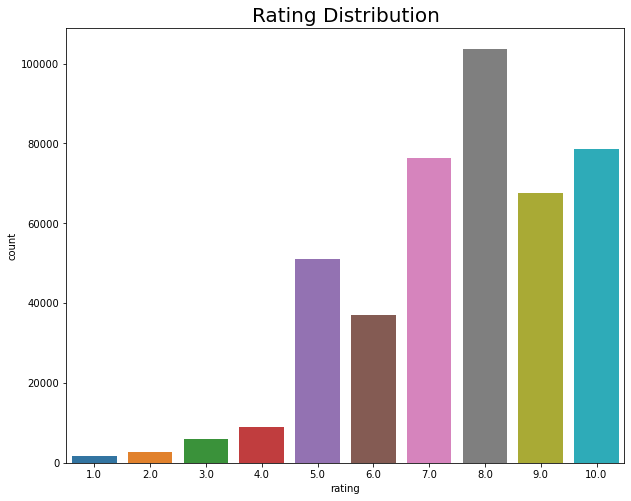

In [24]:
plt.figure(figsize=(10,8))
sns.countplot(x='rating',data=ratings)
plt.title('Rating Distribution',size=20)
plt.show()

In [25]:
ratings.shape

(433671, 3)

In [26]:
#faz mapeamento dos users e books
user_to_idx={j:i+1 for i, j in enumerate(ratings['user_id'].unique())}
book_to_idx={j:i+1 for i,j in enumerate(ratings['isbn'].unique())}
idx_to_user={i+1:j for i, j in enumerate(ratings['user_id'].unique())}
idx_to_book={i+1:j for i,j in enumerate(ratings['isbn'].unique())}

In [27]:
ratings['user_idx']=[user_to_idx[i] for i in ratings['user_id']]
ratings['book_idx']=[book_to_idx[i] for i in ratings['isbn']]

In [28]:
#muda o index
users.set_index('user_id', inplace=True)
books.set_index('isbn',inplace=True)
ratings.set_index('user_id', inplace=True)

In [29]:
ratings.head()

,isbn,rating,user_idx,book_idx
user_id,,,,
276726,0155061224,5.0,1,1
276729,052165615X,3.0,2,2
276729,0521795028,6.0,2,3
276736,3257224281,8.0,3,4
276737,0600570967,6.0,4,5


In [30]:
#cria novo dataset
ratings_idx=ratings[['user_idx','book_idx','rating']]

In [31]:
ratings_idx.head()

,user_idx,book_idx,rating
user_id,,,
276726,1,1,5.0
276729,2,2,3.0
276729,2,3,6.0
276736,3,4,8.0
276737,4,5,6.0


In [32]:
import os
os.chdir(r'/kaggle/working')

In [33]:
books.to_csv(r'books.csv')
users.to_csv(r'users.csv')
ratings.to_csv(r'ratings.csv')
ratings_idx.to_csv(r'ratings_idx.csv',index=False,sep=",")

In [34]:
from IPython.display import FileLink

FileLink(r'books.csv')

/kaggle/working/books.csv

In [35]:
FileLink(r'users.csv')

/kaggle/working/users.csv

In [36]:
FileLink(r'ratings.csv')

/kaggle/working/ratings.csv

In [37]:
FileLink(r'ratings_idx.csv')

/kaggle/working/ratings_idx.csv